# SYDE 411 Project

Best dispatch algorithm (by average wait time): SSTF


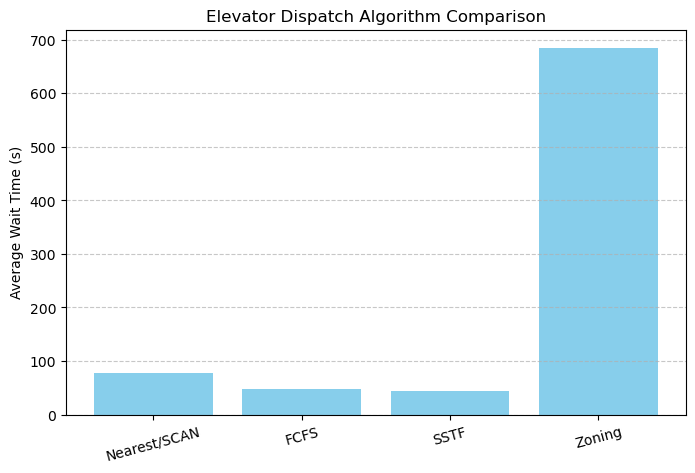

In [24]:

from __future__ import annotations
import heapq
import math
import random
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

@dataclass
class Request:
    id: int
    arrival_time: float
    start_floor: int
    dest_floor: int
    boarded_time: Optional[float] = None
    dropoff_time: Optional[float] = None

    @property
    def direction(self) -> int:
        return 1 if self.dest_floor > self.start_floor else -1

@dataclass
class Elevator:
    id: int
    capacity: int = 10
    speed: float = 1.5
    door_time: float = 5.0
    current_floor: int = 1
    current_time: float = 0.0
    direction: Optional[int] = None
    onboard: List[Request] = field(default_factory=list)
    stops: List[int] = field(default_factory=list)
    total_distance: float = 0.0
    active_time: float = 0.0
    idle_time: float = 0.0

    def load(self) -> int:
        return len(self.onboard)

    def is_full(self) -> bool:
        return self.load() >= self.capacity

    def add_stop(self, floor: int):
        if floor not in self.stops:
            self.stops.append(floor)
            self._resort_stops()

    def remove_stop(self, floor: int):
        if floor in self.stops:
            self.stops.remove(floor)

    def _resort_stops(self):
        if self.direction == 1:
            self.stops.sort()
        elif self.direction == -1:
            self.stops.sort(reverse=True)
        else:
            self.stops.sort()

    def next_stop(self) -> Optional[int]:
        return self.stops[0] if self.stops else None

class Event:
    def __init__(self, time: float, etype: str, payload: dict):
        self.time = float(time)
        self.etype = etype
        self.payload = payload

    def __lt__(self, other: Event):
        return self.time < other.time

class ElevatorSystem:
    def __init__(self, num_floors=33, num_elevators=4, floor_height=3.0,
                 capacity=10, speed=1.5, door_time=5.0):
        self.num_floors = int(num_floors)
        self.floor_height = float(floor_height)
        self.elevators: List[Elevator] = [Elevator(id=i, capacity=capacity, speed=speed, door_time=door_time)
                                          for i in range(num_elevators)]
        self.queues: Dict[int, List[Request]] = {f: [] for f in range(1, self.num_floors + 1)}
        self.events: List[Event] = []
        self.requests: List[Request] = []
        self.time = 0.0
        self.dispatcher = self.dispatch_idle_elevators  # default dispatcher

    # ----------------------------- request generation -----------------------------
    def generate_requests(self, n=100, time_period='peak', rng=None) -> List[Request]:
        rng = np.random.default_rng(rng)
        self.requests = []
        t = 0.0
        for i in range(n):
            if time_period == 'peak':
                t += float(rng.exponential(10.0))
                start = 1 if rng.random() < 0.7 else int(rng.integers(1, self.num_floors + 1))
                if start == 1:
                    dest = int(rng.integers(2, self.num_floors + 1))
                else:
                    dest = int(rng.integers(1, self.num_floors + 1))
                    while dest == start:
                        dest = int(rng.integers(1, self.num_floors + 1))
            else:
                t += float(rng.exponential(5.0))
                start = int(rng.integers(1, self.num_floors + 1))
                dest = int(rng.integers(1, self.num_floors + 1))
                while dest == start:
                    dest = int(rng.integers(1, self.num_floors + 1))
            req = Request(i, t, int(start), int(dest))
            self.requests.append(req)
        for r in self.requests:
            heapq.heappush(self.events, Event(r.arrival_time, 'arrival', {'request': r}))
        return self.requests

    # ----------------------------- time helpers -----------------------------
    def floor_distance_m(self, a: int, b: int) -> float:
        return abs(b - a) * self.floor_height

    def travel_time(self, a: int, b: int, elev: Elevator) -> float:
        if a == b:
            return 0.0
        d = self.floor_distance_m(a, b)
        return d / elev.speed

    # ----------------------------- dispatch algorithms -----------------------------
    def dispatch_idle_elevators(self, at_time: float):
        waiting_floors = [f for f, q in self.queues.items() if q]
        if not waiting_floors:
            return
        idle_elevs = [e for e in self.elevators if not e.stops and e.load() == 0]
        if not idle_elevs:
            return
        waiting_floors.sort(key=lambda f: -len(self.queues[f]))
        for floor in waiting_floors:
            if not self.queues[floor] or not idle_elevs:
                continue
            best = min(idle_elevs, key=lambda e: abs(e.current_floor - floor))
            best.direction = 1 if floor > best.current_floor else -1 if floor < best.current_floor else None
            best.add_stop(floor)
            best._resort_stops()
            tt = self.travel_time(best.current_floor, floor, best)
            arrival_time = max(at_time, best.current_time) + tt
            heapq.heappush(self.events, Event(arrival_time, 'elevator_arrival', {'elevator': best, 'floor': floor}))
            idle_elevs.remove(best)

    def dispatch_fcfs(self, at_time: float):
        idle_elevs = [e for e in self.elevators if not e.stops and e.load() == 0]
        if not idle_elevs:
            return
        waiting_requests = sorted(
            [(floor, req) for floor, queue in self.queues.items() for req in queue],
            key=lambda x: x[1].arrival_time
        )
        if not waiting_requests:
            return
        for floor, req in waiting_requests:
            if not idle_elevs:
                break
            best = idle_elevs.pop(0)
            best.direction = 1 if floor > best.current_floor else -1 if floor < best.current_floor else None
            best.add_stop(floor)
            best._resort_stops()
            travel = self.travel_time(best.current_floor, floor, best)
            arrival_time = max(at_time, best.current_time) + travel
            heapq.heappush(self.events, Event(arrival_time, 'elevator_arrival', {'elevator': best, 'floor': floor}))

    def dispatch_sstf(self, at_time: float):
        waiting_floors = [f for f, q in self.queues.items() if q]
        idle_elevs = [e for e in self.elevators if not e.stops and e.load() == 0]
        if not waiting_floors or not idle_elevs:
            return
        while waiting_floors and idle_elevs:
            for elev in list(idle_elevs):
                nearest_floor = min(waiting_floors, key=lambda f: abs(f - elev.current_floor))
                elev.direction = 1 if nearest_floor > elev.current_floor else -1 if nearest_floor < elev.current_floor else None
                elev.add_stop(nearest_floor)
                elev._resort_stops()
                travel = self.travel_time(elev.current_floor, nearest_floor, elev)
                arrival_time = max(at_time, elev.current_time) + travel
                heapq.heappush(self.events, Event(arrival_time, 'elevator_arrival', {'elevator': elev, 'floor': nearest_floor}))
                waiting_floors.remove(nearest_floor)
                idle_elevs.remove(elev)
                if not waiting_floors or not idle_elevs:
                    break

    def dispatch_zoning(self, at_time: float):
        idle_elevs = [e for e in self.elevators if not e.stops and e.load() == 0]
        if not idle_elevs:
            return
        floors_per_elevator = math.ceil(self.num_floors / len(self.elevators))
        for elev in idle_elevs:
            zone_start = elev.id * floors_per_elevator + 1
            zone_end = min((elev.id + 1) * floors_per_elevator, self.num_floors)
            zone_floors = [f for f in range(zone_start, zone_end + 1) if self.queues[f]]
            if not zone_floors:
                continue
            target_floor = max(zone_floors, key=lambda f: len(self.queues[f]))
            elev.direction = 1 if target_floor > elev.current_floor else -1 if target_floor < elev.current_floor else None
            elev.add_stop(target_floor)
            elev._resort_stops()
            travel = self.travel_time(elev.current_floor, target_floor, elev)
            arrival_time = max(at_time, elev.current_time) + travel
            heapq.heappush(self.events, Event(arrival_time, 'elevator_arrival', {'elevator': elev, 'floor': target_floor}))

    # ----------------------------- event handlers -----------------------------
    def handle_passenger_arrival(self, req: Request):
        self.queues[req.start_floor].append(req)
        if self.dispatcher:
            self.dispatcher(self, req.arrival_time)

    def handle_elevator_arrival(self, elev: Elevator, floor: int, event_time: float):
        elev.current_time = event_time
        elev.total_distance += self.floor_distance_m(elev.current_floor, floor)
        elev.current_floor = floor

        # alight
        alighting = [p for p in elev.onboard if p.dest_floor == floor]
        for p in alighting:
            p.dropoff_time = event_time + elev.door_time
            elev.onboard.remove(p)

        # board
        queue = self.queues[floor]
        boarding_candidates = queue if elev.direction is None else \
            [r for r in queue if r.direction == elev.direction] + [r for r in queue if r.direction != elev.direction]

        t_board_start = event_time
        while boarding_candidates and not elev.is_full():
            r = boarding_candidates.pop(0)
            if r in queue:
                queue.remove(r)
            elev.onboard.append(r)
            r.boarded_time = t_board_start
            elev.add_stop(r.dest_floor)

        elev._resort_stops()
        depart_time = t_board_start + elev.door_time

        if elev.stops:
            next_floor = elev.next_stop()
            elev.remove_stop(next_floor)
            elev.direction = 1 if next_floor > elev.current_floor else -1 if next_floor < elev.current_floor else elev.direction
            travel = self.travel_time(elev.current_floor, next_floor, elev)
            arrival_time = depart_time + travel
            elev.active_time += depart_time - event_time + travel
            heapq.heappush(self.events, Event(arrival_time, 'elevator_arrival', {'elevator': elev, 'floor': next_floor}))
        else:
            elev.direction = None
            elev.idle_time += elev.door_time
            elev.active_time += elev.door_time
            elev.current_time = depart_time
            if self.dispatcher:
                self.dispatcher(self, depart_time)

    # ----------------------------- metrics -----------------------------
    def calculate_metrics(self) -> Dict[str, float]:
        served = [r for r in self.requests if r.boarded_time is not None and r.dropoff_time is not None]
        wait_times = [r.boarded_time - r.arrival_time for r in served]
        service_times = [r.dropoff_time - r.boarded_time for r in served]

        avg_wait = np.mean(wait_times) if wait_times else 0.0
        max_wait = max(wait_times) if wait_times else 0.0
        total_service = sum(service_times) if service_times else 0.0
        total_distance = sum(e.total_distance for e in self.elevators)
        total_active = sum(e.active_time for e in self.elevators)
        total_idle = sum(e.idle_time for e in self.elevators)
        energy = total_distance * 0.05 + total_active * 0.01

        return {
            'served': len(served),
            'avg_wait_time': avg_wait,
            'max_wait_time': max_wait,
            'total_service_time': total_service,
            'total_distance': total_distance,
            'total_active_time': total_active,
            'total_idle_time': total_idle,
            'energy': energy,
        }

# Benchmark different dispatch algorithms
# Mapping of algorithms
dispatchers = {
    'Nearest/SCAN': ElevatorSystem.dispatch_idle_elevators,
    'FCFS': ElevatorSystem.dispatch_fcfs,
    'SSTF': ElevatorSystem.dispatch_sstf,
    'Zoning': ElevatorSystem.dispatch_zoning
}

num_requests = 100
num_runs = 3
results = {name: [] for name in dispatchers.keys()}

for name, dispatcher in dispatchers.items():
    avg_waits = []
    for run_id in range(num_runs):
        sys = ElevatorSystem(num_floors=33, num_elevators=4, capacity=8, speed=1.5, door_time=4.0)
        sys.dispatcher = dispatcher
        sys.generate_requests(num_requests, time_period='peak', rng=42+run_id)
        while sys.events:
            ev = heapq.heappop(sys.events)
            sys.time = ev.time
            if ev.etype == 'arrival':
                req = ev.payload['request']
                sys.handle_passenger_arrival(req)
            elif ev.etype == 'elevator_arrival':
                elev = ev.payload['elevator']
                floor = ev.payload['floor']
                elev = next((e for e in sys.elevators if e.id == elev.id), elev)
                sys.handle_elevator_arrival(elev, floor, ev.time)
        metrics = sys.calculate_metrics()
        avg_waits.append(metrics['avg_wait_time'])
    results[name] = np.mean(avg_waits)

best_alg = min(results, key=results.get)
print("Best dispatch algorithm (by average wait time):", best_alg)

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel('Average Wait Time (s)')
plt.title('Elevator Dispatch Algorithm Comparison')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
